In [ ]:
import numpy as np
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
import os
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
from collections import defaultdict, deque
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm_notebook, trange

def seed_everything(seed = 42): 
  random.seed(seed) 
  os.environ['PYTHONHASHSEED'] = str(seed) 
  np.random.seed(seed)
  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed) 
  torch.backends.cudnn.deterministic = True

seed_everything()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

MessageError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/CS259

/content/gdrive/MyDrive/CS259


In [ ]:
%ls

all_labels_1024.npz  all_labels.npz        cache_replacement.ipynb
all_labels_b.npz     all_labels_small.npz  llc_access_trace.csv
all_labels_full.npz  all_labels_three.npz  model/


In [ ]:
all_data = np.load('./all_labels_full.npz', allow_pickle=True)

In [ ]:
np.unique(all_data['y']) 

array([0, 1, 2])

In [ ]:
np.count_nonzero(all_data['y'] == 2)

10080

In [ ]:
np.count_nonzero(all_data['y'] == 0)

13614

In [ ]:
np.count_nonzero(all_data['y'] == 1)

8719

In [ ]:
X, y = all_data['x'], all_data['y']

In [ ]:
X, y = shuffle(X, y, random_state=0)

In [ ]:
class cacheDataset(Dataset):
    def __init__(self, X, Y):
        self.data = X
        self.target = Y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

## Need to encode x someway that makes sense

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)

In [ ]:
def to_number(X):
  new_x = []
  for x in X:
    #tmp = [int(x[0], 16), int(x[1], 16), int(x[2], 16)]
    tmp = [int(x[0], 16), int(x[1], 16)]
    new_x.append(np.array(tmp))
  return np.array(new_x)

In [ ]:
def to_numpy(X):
  new_x = []
  for x in X:
    #tmp = [int(x[0], 16), int(x[1], 16), int(x[2], 16)]
    tmp = [x[0], x[1]]
    new_x.append(np.array(tmp))
  new_x = np.array(new_x)
  onehot_encoded = onehot_encoder.fit_transform(new_x)
  return onehot_encoded

In [ ]:
Xb = to_number(X)

In [ ]:
Xb = to_numpy(X)

In [ ]:
trainX = Xb[:int(len(y)*0.8)]
trainY = y[:int(len(y)*0.8)]
validX = Xb[int(len(y)*0.8):]
validY = y[int(len(y)*0.8):]

In [ ]:
train_X = torch.from_numpy(trainX)
train_y = torch.from_numpy(trainY)
valid_X  = torch.from_numpy(validX)
valid_y = torch.from_numpy(validY)


In [ ]:
train_X = torch.FloatTensor(trainX)
valid_X = torch.FloatTensor(validX)
# train_X = torch.from_numpy(trainX)
# valid_X = torch.from_numpy(validX)

In [ ]:
train_dataset = cacheDataset(train_X, train_y)
valid_dataset = cacheDataset(valid_X, valid_y)


In [ ]:
def bestmodel(model_name,save_model_time,valid_loss):
    bestloss = 10000
    if valid_loss < bestloss :
        bestloss = valid_loss
        torch.save(model_name, 'model/model{save_model_time}/bestmodel.pkl'.format(save_model_time=save_model_time))
        torch.save(model_name.state_dict(), 'model/model{save_model_time}/net_params_bestmodel.pkl'.format(save_model_time=save_model_time))
    return True  

In [ ]:
CACHE_SIZE=1024

In [ ]:
save_model_time = '2'
mkpath = 'model/model%s'% save_model_time

In [ ]:
class TrainHelper():
    '''
    Helper class that makes it a bit easier and cleaner to define the training routine
    
    '''

    def __init__(self,model,train_set,test_set,opts):
      self.model = model  # neural net

      # device agnostic code snippet
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.model.to(self.device)

      self.epochs = opts['epochs']
      self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent

      #self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
      self.criterion = nn.NLLLoss()
      
      self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                      batch_size=opts['batch_size'],
                                                      shuffle=True)
      self.valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                      batch_size=opts['batch_size'],
                                                      shuffle=True)
    def train(self):
      self.model.train() # put model in training mode
      for epoch in range(self.epochs):
          self.tr_loss = []
          for i, (data,labels) in tqdm_notebook(enumerate(self.train_loader),
                                                  total = len(self.train_loader)):

              data, labels = data.to(self.device),labels.to(self.device)
              self.optimizer.zero_grad()  
              outputs = self.model(data)

              loss = self.criterion(outputs, labels)                  # loss function
              # loss.backward()           
              self.optimizer.step()                  
              self.tr_loss.append(loss.item())       
          if (epoch+1) % 5 == 0 or epoch == 0: # save the model every _ epoch

              torch.save(self.model, 'model/model{save_model_time}/net_{epoch}.pkl'.format(save_model_time=save_model_time,epoch=int((epoch+1)/5)))
              torch.save(self.model.state_dict(), 'model/model{save_model_time}/net_params_{epoch}.pkl'.format(save_model_time=save_model_time,epoch=int((epoch+1)/5)))
          
          self.test(epoch) # run through the validation set

    def test(self,epoch):
            
      self.model.eval()    # puts model in eval mode
      self.test_loss = []
      self.test_accuracy = []

      for i, (data, labels) in enumerate(self.valid_loader):
          
          data, labels = data.to(self.device),labels.to(self.device)
          # pass data through network
          # turn off gradient calculation to speed up calcs and reduce memory
          with torch.no_grad():
              outputs = self.model(data)

          # make our predictions and update our loss info
          _, predicted = torch.max(outputs.data, 1)
          loss = self.criterion(outputs, labels) 

          self.test_loss.append(loss.item())
          # print(predicted)
          # print(labels)
          self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
      
      test_loss.append(np.mean(self.test_loss))
      train_loss.append(np.mean(self.tr_loss))
      bestmodel(self.model,save_model_time,np.mean(self.test_loss)) # find best model
      print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
            epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, CACHE_SIZE, 2)
            nn.Conv1d(
                in_channels=1,              # input height
                out_channels=8,            # n_filters
                kernel_size=2,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image afte#
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv1d(
                in_channels=8,              # input height
                out_channels=16,            # n_filters
                kernel_size=2,              # filter size
                stride=1,                   # filter movement/step
                padding=2),    # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
        )
        self.out = nn.Sequential(
            nn.Linear(128,100), #128 144
            )
        self.fc1 = torch.nn.Linear(100, 3) #128 192
    def forward(self, x):
        x = x.unsqueeze(1)
        # x = x.permute(1, 0, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 *#
        x = self.out(x)
        x = self.fc1(x)
  
        return x

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__() 
        
        self.conv1 = nn.Sequential(         
            nn.Conv1d(
                in_channels=1,             
                out_channels=32,            
                kernel_size=8,          
                stride=1,                  
                padding=0,                  
            ),                              
            nn.ReLU(),
            nn.MaxPool1d(4),                 
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=32,             
                out_channels=64,            
                kernel_size=8,          
                stride=1,                  
                padding=0,                  
            ),                              
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=64,             
                out_channels=128,            
                kernel_size=8,          
                stride=1,                  
                padding=0,                  
            ),                              
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        # self.conv2 = torch.nn.Conv2d(32, 64, 3)
        # self.conv3 = torch.nn.Conv2d(64, 128, 3)
        # self.pool = torch.nn.MaxPool2d(4)
        self.fc = torch.nn.Linear(14848, CACHE_SIZE)
        self.fc2 = torch.nn.Linear(CACHE_SIZE, 256)
        self.fc1 = torch.nn.Linear(256, 3) #128 192
        self.fc1 = torch.nn.Linear(128, 3) #128 192

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        # x = self.relu(x)
        # x = self.pool(x)
        x = self.conv2(x)
        # x = self.relu(x)
        # x = self.pool(x)
        x = self.conv3(x)
        # x = self.relu(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)
        # x = self.fc2(x)
        x = self.fc1(x)
        
        # x = F.log_softmax(x, dim=1)
        return x

In [ ]:
len(train_X[0])

7579

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__() 
        self.l = nn.LSTM(7579, CACHE_SIZE, 2, batch_first=True)
        self.s = nn.Linear(CACHE_SIZE, 3)

    def forward(self, x):
        out, _ = self.l(x)
        tag_space = self.s(out.view(len(x), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
model = LSTM()
# model = VGG()
# model = CNN()
opts = {
    'lr': 5e-5,
    'epochs': 25,
    'batch_size': 100,
}

In [ ]:
test_loss, train_loss = [], []
CNNTrainer = TrainHelper(model = model,
                      train_set = train_dataset,
                      test_set = valid_dataset, opts = opts)

In [ ]:
CNNTrainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 1, train loss: 1.0985880883840413, test loss: 1.0985762431071355, test accuracy: 0.31417608897126975


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 2, train loss: 1.0985931579883281, test loss: 1.0985728355554434, test accuracy: 0.31379796107506946


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 3, train loss: 1.0985904936607067, test loss: 1.098580340238718, test accuracy: 0.3137979610750695


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 4, train loss: 1.0985769918331734, test loss: 1.0985691455694346, test accuracy: 0.3139870250231696


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 5, train loss: 1.09858749463008, test loss: 1.098578012906588, test accuracy: 0.31401853568118626


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 6, train loss: 1.0985871470891513, test loss: 1.0985645239169781, test accuracy: 0.31395551436515295


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 7, train loss: 1.0985866638330313, test loss: 1.0985716618024386, test accuracy: 0.31392400370713625


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 8, train loss: 1.0985893437495597, test loss: 1.0985660956456111, test accuracy: 0.31392400370713625


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 9, train loss: 1.098595253779338, test loss: 1.0985741762014536, test accuracy: 0.3139870250231696


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 10, train loss: 1.0985876308037685, test loss: 1.0985546808976394, test accuracy: 0.3140815569972196


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 11, train loss: 1.0985879719257354, test loss: 1.0985666054945726, test accuracy: 0.3140815569972197


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 12, train loss: 1.0985801119070786, test loss: 1.0985581398010253, test accuracy: 0.3138609823911029


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 13, train loss: 1.098593740279858, test loss: 1.0985678012554463, test accuracy: 0.31398702502316955


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 14, train loss: 1.0985983105806203, test loss: 1.0985662405307477, test accuracy: 0.31417608897126975


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 15, train loss: 1.0985830155702738, test loss: 1.098560461631188, test accuracy: 0.31392400370713625


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 16, train loss: 1.0985928471271809, test loss: 1.0985875496497521, test accuracy: 0.3141760889712697


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 17, train loss: 1.098595673762835, test loss: 1.098567847105173, test accuracy: 0.3140815569972196


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 18, train loss: 1.0985975921154023, test loss: 1.098579403070303, test accuracy: 0.3139870250231696


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 19, train loss: 1.0985906137869907, test loss: 1.0985603442558876, test accuracy: 0.3139870250231696


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 20, train loss: 1.0985882841623746, test loss: 1.0985575125767635, test accuracy: 0.314144578313253


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 21, train loss: 1.0985899741833027, test loss: 1.0985560380495512, test accuracy: 0.31420759962928635


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 22, train loss: 1.0985924110962795, test loss: 1.0985676215245173, test accuracy: 0.31395551436515295


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 23, train loss: 1.0985991592590625, test loss: 1.0985943904289832, test accuracy: 0.31401853568118626


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 24, train loss: 1.0985816056911761, test loss: 1.0985825611994817, test accuracy: 0.31392400370713625


  0%|          | 0/260 [00:00<?, ?it/s]

epoch: 25, train loss: 1.098572169817411, test loss: 1.0985551063831036, test accuracy: 0.3140815569972196


In [ ]:
def pltloss(train_loss, test_loss, epoch):
    epochs = [i for i in range(epoch)]
    fig = plt.figure()
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, test_loss, 'b', label='Testing loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

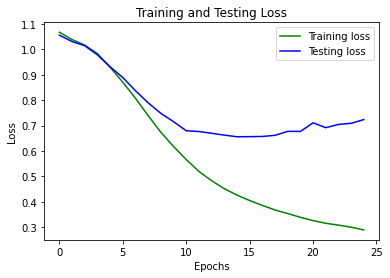

In [ ]:
pltloss(train_loss, test_loss, 25)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
classes = 3
def confusion(test_loader, classifier):
    M = np.zeros((classes,classes))
    predict = []
    label = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i, (data, labels) in enumerate(test_loader):
      data, labels = data.to(device),labels.to(device)
      label.extend(labels.tolist())
    # pass data through network
    # turn off gradient calculation to speed up calcs and reduce memory
      with torch.no_grad():
        outputs = classifier(data)
    # make our predictions and update our loss info
      _, predicted = torch.max(outputs.data, 1)
      predict.extend(predicted.tolist())

    tmp = [i for i in range(classes)]
    M = confusion_matrix(label, predict, labels = tmp)
    print(M.diagonal()/M.sum(axis=1))
    return M

def visualize_confusion(M):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    tmp = [i for i in range(classes)]
    cm = ConfusionMatrixDisplay(M, display_labels = tmp);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    # plt.xticks(rotation = 20)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                      batch_size=opts['batch_size'],
                                                      shuffle=True)

In [ ]:
M = confusion(test_loader, model)

[0. 1. 0.]


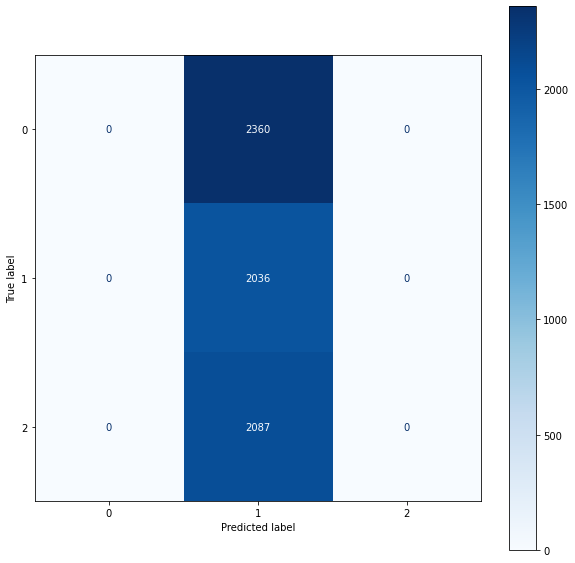

In [ ]:
visualize_confusion(M)

In [ ]:
def get_list(model, loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    result = []
    inc = 0
    t = 0
    for i, (data, labels) in enumerate(loader):
      data, labels = data.to(device),labels.to(device)
    # pass data through network
    # turn off gradient calculation to speed up calcs and reduce memory
      with torch.no_grad():
        outputs = model(data)
    # make our predictions and update our loss info
      _, predicted = torch.max(outputs.data, 1)
      for i in range(len(labels)):
        t += 1
        if labels[i] != predicted[i]:
          inc += 1
        result.append(predicted[i].item())
    print(inc/t)
    return result

In [ ]:
l = get_list(model, test_loader)

0.5852334419109664


In [ ]:
from collections import Counter

In [ ]:
Counter(l)

Counter({0: 763, 1: 506, 2: 573})

In [ ]:
df = pd.read_csv('llc_access_trace.csv', sep=',',header = None)
df.columns = ["PC", "Address"]

In [ ]:
Xall = df.to_numpy()

In [ ]:
allX = to_numpy(Xall)

In [ ]:
allY = np.zeros(len(allX))

In [ ]:
# allX, allY = shuffle(allX, allY, random_state=0)
all_X = torch.FloatTensor(Xb)
all_Y = torch.from_numpy(y) 

In [ ]:
all_dataset = cacheDataset(all_X, all_Y)

In [ ]:
all_loader = torch.utils.data.DataLoader(dataset=all_dataset,
                                                      batch_size=1,
                                                      shuffle=True)

In [ ]:
choices = []
def hitRate(all_loader, model):
    cache = set()
    lru_recency = deque()
    lfu_frequency = defaultdict()
    fifo_order = deque()

    hit, miss = 0, 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for i, row in enumerate(X):
    # for i, (data, _) in enumerate(all_loader):
          trace = row[1]
          if trace in cache:
              hit += 1
              # update the lfu frequency
              lfu_frequency[trace] += 1
              # update the lfu
              lru_recency.remove(trace)
              lru_recency.append(trace)
          elif len(cache) < CACHE_SIZE:
              cache.add(trace)
              # update the lfu
              lfu_frequency[trace] = 1
              # update the lru
              lru_recency.append(trace)
              # update the fifo
              fifo_order.append(trace)
              miss += 1
          else:
              miss += 1
              # lfu propse a candidate
              lfu_candidate, f = min(lfu_frequency.items(), key=lambda a: a[1])
              # lru propose a candidate
              lru_candidate = lru_recency[0]
              # fifo propose a candidate
              fifo_candidate = fifo_order[0]
              candidates = [lfu_candidate, lru_candidate, fifo_candidate]
              data, _ = next(iter(all_loader))
              data = data.to(device)
              with torch.no_grad():
                  outputs = model(data)
              _, predicted = torch.max(outputs.data, 1)
              # if predicted != 0: print('no')
              picked_candidate = candidates[predicted.item()]
              choices.append(predicted.item())

              cache.remove(picked_candidate)
              cache.add(trace)

              # update the meta data
              # update the lru meta data
              lru_recency.remove(picked_candidate)
              lru_recency.append(trace)
              # update the lfu meta data
              lfu_frequency.pop(picked_candidate)
              lfu_frequency[trace] = 1
              #
              fifo_order.remove(picked_candidate)
              fifo_order.append(trace)

    hitrate = hit / (hit + miss)
    print(hit)
    print(miss)
    return hitrate

In [ ]:
hitRate(all_loader, model)

9036
23377


0.2787770339061488

In [ ]:
Counter(choices)

Counter({0: 9389, 1: 6034, 2: 6948})